# <center> Benford's Law and COVID-19 Reporting </center>


## Motivations
COVID-19 has touched the lives of people all around the globe and there has been a quick dash to understand the virus from a biological standpoint but also the spread from a probabilistic standpoint. The effect's of COVID-19 will be long lasting not only from the stand point of precautionary norms (such as masks, and perhaps the disappearence of handshake's), we also see new trends come to light that appear as if they are here to stay such as working from home.

In the early day's of the pandemic, there was speculation as to the accuracy of some of the new case numbers various countries were reporting. Much, if not most, of this was likely a function of the availability of testing. For my own curiousity, I wanted to explore the notion of Benford's Law and how it relates to the number of new case's being reported by country.After this, I decided to explore the relationship's between empirical and theoretical distributions of this law via the use of the Kullback-Leibler Divergence to explore entropy between the two sets.

## What is Benford's Law?

Benford's law states pertains to the frequency of leading integers in sets of naturally occuring observations. For example, if we had the number 109, the leading integer would be 1. 

One of the main applications of this law is it's applications in fraud detection.Benford's law is widely used in financial reporting fraud as well as scientific data forging. The law is stated below which shows the expected probability of the leading integer occuring in a set as the following, for i in {1,...,9}: 
<b>$$\log_{10} (1+ \frac{1}{i})$$</b>

This yields us the following probabilities for each integer 1 through 9:

|Integer     | Probability     |
|:---        | :---:     |
|1           | 30.1%     |
|2           | 17.6%     |
|3           | 12.5%     |
|4           | 9.7%      |
|5           | 7.9%      |
|6           | 6.7%      |
|7           | 5.8%      |
|8           | 5.1%      |
|9           | 4.6%      |


## Methods
### Statistical Analysis
For our statistical analysis, I opted to use both the <b>Chi-Squar</b> and the <b>Kolmogorov–Smirnov Test</b>. For these statistical tests we will be looking at our <i>p-values</i> to check for statistical significance between the empirical distribution observed in our data by country and the expected distribution based on the Benford probabilities listed above. 
Recall since this is a goodness of fit test, we are checking to see whether there is significant 'evidence' to reject the null hypothesis <i>$H_0$</i>, as to imply that at least at our confidence level, we are not able to conclude that the data came from a Benford Distribution.

### Relative Entropy Analysis
I will be using the Kulback-Leibler Divergence score to explore a quantified amount of 'mutual information' between the empirical and theoretical sets.


## Data
Our the data we will be working with is pulled directly from Our World in Data https://covid.ourworldindata.org/data/owid-covid-data.csv 

We will primarily be working with the 'new_cases' column of the data which represents the number of new reported cases fo each country on a specified day.

## Conditioning


In [3]:
#Data Manipulation
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
from scipy.stats import ks_2samp
from scipy.stats import chisquare
from scipy.stats import entropy

# Visualizations
import matplotlib.pyplot as plt

#Import
covid_df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [6]:
#Basic Conditioning
covid_df['date'] = covid_df['date'].apply(pd.to_datetime, errors = 'coerce')
covid_df['new_cases'] = covid_df['new_cases'].fillna(0)
covid_df['new_cases'] = covid_df['new_cases'].astype(int)

## Building the Functions
One of my goals when thinking about the most efficient way to tackle this project, was to create a function that would allow itself to be generizeable for other analysis (for example if I wanted to examine this same relation with Benford's law with reported deaths instead of reported new cases).

This function has 9 separate outputs which then get appended to their respective lists. The output is as follows:
<ul type = "square">
    <li><b>country_list</b>: The name of the country for which the data pertains to </li>
    <li><b>p_ChiSq</b>: The p-value of the Chi Square test of the empirical data versus the theoretical data</li>
    <li><b>p_ks </b>: The p-value of the Kolmogorov–Smirnov Test</li>
    <li><b>obs_count</b>: The number of observations in the dataset for this particular country (equivalently, the number of days of data we have. </li>
    <li><b>expected_dists</b>: This is the expected frequency of each integer based on Benford's Law. Simply computed by        $N \cdot probability[i]$ where <i>i</i> is the corresponding integer probability (ie. 30.1% for 1, etc.)</li>
    <li><b>observed_dists</b>: The actual frequency count of leading integers in the data </li>
    <li><b>observed_probs</b>: The probability of each leading integer in the empirical data for that particular country </li>
    <li><b>chi_sqVal</b>: The actual Chi Square Statistic from our Chi Square test</li>
    <li><b>kldiv_score</b>: The Kullback-Leibler Divergence Score </li>
        
          
</ul><br/>  


In [73]:
#Building empty lists for the sake of computation since we will join different ones for various tasks below#
country_list = []
p_ChiSq = []
p_ks = []
obs_count = []
expected_dists = []
observed_dists = []
observed_probs = []
chi_sqVal = []

benford_probabilities = [round(math.log10(1+(1.0/i)), 3) for i in range(1,10)]

#Need to get a count of all the unique leading integers, their respective percentages
def digits(df, df_column, country):
    """Creating a function that will output: (1) Frequency count of leading ints, (2) Proportion, (3) length of array"""
    def leading_int(x):
        """Assumes x is a int -- Just some helper function"""
        return int(str(abs(x))[0])
    leading_digits = [leading_int(num) for num in df[df_column]]
    observed_distributions = [leading_digits.count(i) for i in range(1,10)]
    number_observations = sum(observed_distributions) #Treated as our total count since every day will have a leading integer
    expected_distributions = [int(benford_probabilities[i] * number_observations) for i in range(0,9)] #Theoretical Distribution
    probability_vals = [(nums/float(number_observations)) for nums in observed_distributions]

    ##########################
    # Goodness of Fit Testing
    ##########################
    #Chi-Square
    sig_val_chi = round(chisquare(observed_distributions, expected_distributions)[1],5)
    chi_sq_stat = chisquare(observed_distributions, expected_distributions)[0]

    #Kolmogorov-Smirnov
    sig_val_ks = ks_2samp(observed_distributions, expected_distributions)[1]
    
    #########################
    # Append into lists for DF
    #########################
    country_list.append(country)
    p_ChiSq.append(sig_val_chi)
    p_ks.append(sig_val_ks)
    obs_count.append(number_observations)
    expected_dists.append(expected_distributions)
    observed_dists.append(observed_distributions)
    observed_probs.append(probability_vals)
    chi_sqVal.append(chi_sq_stat)


### Generating the data
For the sake of our own analysis, we decided to limit our function to the top 14 countries in terms of total COVID-19 reported cases.From these, we fed the list of 30 into the function constructed above.

The 30 countries are:

In [71]:
top14_countries  = pd.pivot_table(covid_df, values = ['new_cases'], index = ['location'], aggfunc = np.sum)['new_cases'].sort_values(ascending = False)[1:31].reset_index()['location'] #Ommiting index 0 because the world has the most!
top14_countries

0      United States
1              India
2             Brazil
3             Russia
4          Argentina
5           Colombia
6              Spain
7               Peru
8             Mexico
9             France
10      South Africa
11    United Kingdom
12              Iran
13             Chile
14              Iraq
15        Bangladesh
16             Italy
17         Indonesia
18       Philippines
19           Germany
20            Turkey
21      Saudi Arabia
22          Pakistan
23            Israel
24           Ukraine
25       Netherlands
26            Canada
27           Belgium
28           Romania
29           Morocco
Name: location, dtype: object

In [74]:
#Running the function
for country in range(len(top14_countries)):
    digits(covid_df[covid_df['location'] == top14_countries[country]], 'new_cases', str(top14_countries[country]))
stats_covid = pd.DataFrame({'Country':country_list, 'Chi-Square p-Value':p_ChiSq, 'KS p-Value': p_ks, 
    'Total Observations': obs_count})
stats_covid = stats_covid[['Country', 'Chi-Square p-Value', 'KS p-Value', 'Total Observations' ]]
stats_covid

,Country,Chi-Square p-Value,KS p-Value,Total Observations
0,United States,0.00000,0.603001,247
1,India,0.00000,0.603001,230
2,Brazil,0.00000,0.249996,226
3,Russia,0.00000,0.957475,223
4,Argentina,0.00001,0.957475,211
5,Colombia,0.00000,0.957475,219
6,Spain,0.01361,0.957475,206
7,Peru,0.00000,0.603001,220
8,Mexico,0.00000,0.603001,222
9,France,0.09931,0.957475,224


## Plotting our findings
Below we will show histogram's of our top countries from above. The bar chart frequencies represent the actual count from the data whereas the lines represent the expected distributions based on Benford's Law. For the sake of graphing we have limited the plots to the top 14 countries

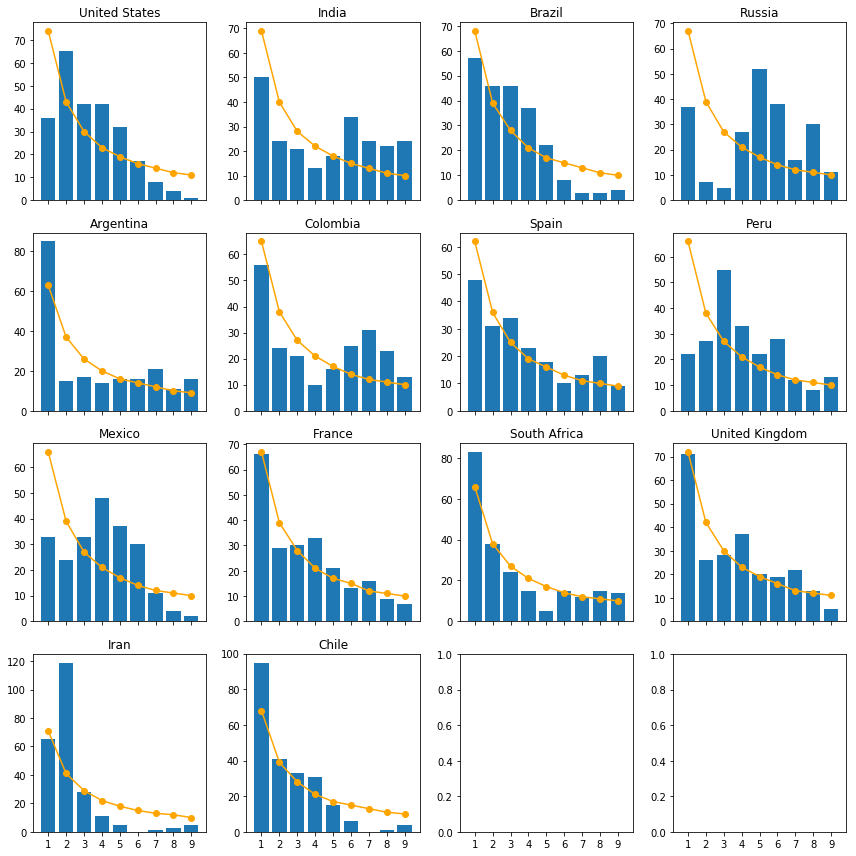

In [62]:
results_zipped = zip(observed_dists, expected_dists, country_list)
fig, axs = plt.subplots(4,4, sharex = 'col', figsize = (12,12 ))
#fig.suptitle("Leading Integers of new cases for COVID-19", fontweight = 'bold', fontsize = 'small')
axs = axs.ravel()
for i in range(len(results_zipped)):
    axs[i].plot(range(1,10), results_zipped[i][1], linestyle = '-', marker = 'o', color = 'orange') #Theoretical Distribution
    axs[i].bar(range(1,10), results_zipped[i][0]) #Observed Distributions
    axs[i].title.set_text(str(results_zipped[i][2]))
    axs[i].set_xticks(range(1,10))
    
fig.tight_layout()
plt.show()

## Exploratory Figures
For this portion, we narrowed the countries down to the top 5 with respect to total cases, so that we can view trendlines of various features

In [64]:
top5_countries = top14_countries[0:5]
graph_df = covid_df[covid_df['location'].isin(top5_countries)]
now = datetime.date.today()

### Positivity Rate 

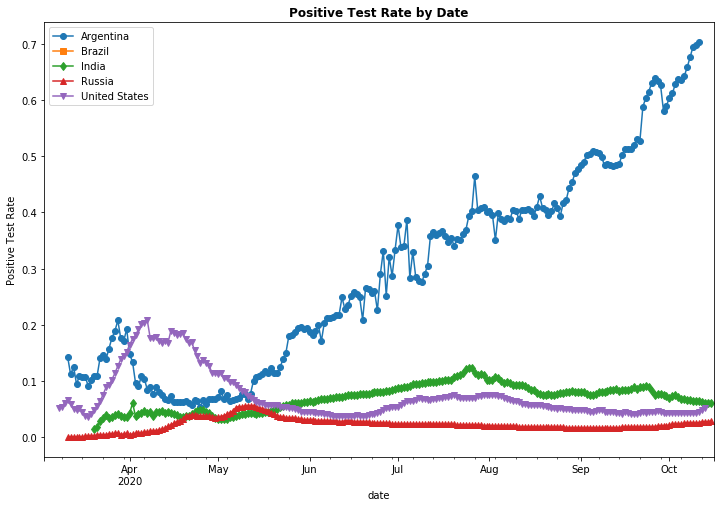

In [67]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('Date of Data')
ax.set_ylabel('Positive Test Rate')
markers = ['o', 's', 'd', '^', 'v']
for key, grp in graph_df.groupby(['location']):
    ax = grp.plot(ax = ax, kind = 'line', x = 'date', y = 'positive_rate', label = key)
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
plt.legend(loc = 'best')
plt.gca().set_xbound(datetime.date(2020,3,3), now)
plt.title("Positive Test Rate by Date", fontweight = "bold")
plt.show()

### Number of Deaths

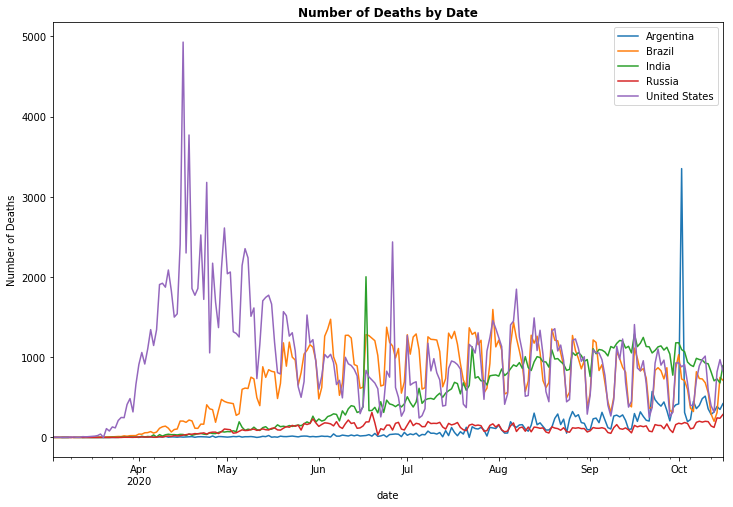

In [68]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('Date of Data')
ax.set_ylabel('Number of Deaths')
for key, grp in graph_df.groupby(['location']):
    ax = grp.plot(ax = ax, kind = 'line', x = 'date', y = 'new_deaths', label = key)
plt.legend(loc = 'best')
plt.gca().set_xbound(datetime.date(2020,3,3), now)
plt.title("Number of Deaths by Date", fontweight = "bold")
plt.show()

### Number of Tests

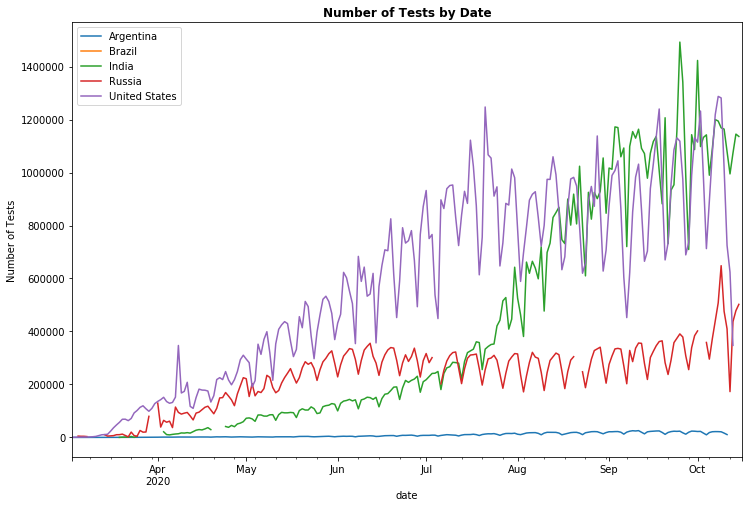

In [69]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('Date of Data')
ax.set_ylabel('Number of Tests')
for key, grp in graph_df.groupby(['location']):
    ax = grp.plot(ax = ax, kind = 'line', x = 'date', y = 'new_tests', label = key)
plt.legend(loc = 'best')
plt.gca().set_xbound(datetime.date(2020,3,3), now)
plt.title("Number of Tests by Date", fontweight = "bold")
plt.show()

## Results
From our Goodness of Fit tests conducted above, we are able to look at a few countires which are statistically significant at the 95% Confidence level for both the Chi Square test and the Kolmogorov–Smirnov test. Since the Kolmogorov-Smirnov (two-tail) test is non-parametric it does not assume any sort of underlying distributions. The countries which fail at the 90% Confidence level for both the Chi Square and KS Test are

In [77]:
stats_covid[(stats_covid['Chi-Square p-Value'] <= 0.100) & (stats_covid['KS p-Value'] <= 0.1000)]

,Country,Chi-Square p-Value,KS p-Value,Total Observations
12,Iran,0.0,0.077848,237
15,Bangladesh,0.0,0.077848,210
28,Romania,0.0,0.077848,227


## Conclusions
Most countries will not follow Benford's Law perfectly well. This is likely a function of time (for example, as time increased with the COVID pandemic, so too did the output of tests and many days might be accounting for backlog from prior days. This is why we opted to also use the KS test too. It turns out that most countries fail 1 of the 2 statistical tests however these three particularly fail both which may warrant further analysis and exploration of their data